# MDA project: predicting crowdedness in Leuven through noise and weather data

### Importing packages

In [33]:
import pandas as pd
import numpy as np
from matplotlib.patches import Patch
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import SplineTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error


### Loading data and adding time-related features

In [3]:
df = pd.read_csv("C:\\Users\Arthur\hello\\final_df.csv", delimiter=";")
df['result_timestamp'] = pd.to_datetime(df['result_timestamp'], format='%Y-%m-%d %H:%M:%S')
#select only three locations close to Oude Markt
df = df[df['object_id']<255442]
df

,object_id,result_timestamp,laeq,hour,day_of_week,month,weekend,holiday,exam_period,key,...,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0,LC_TEMP_QCL1,LC_TEMP_QCL2,LC_TEMP_QCL3
0,255441,2022-01-01 00:00:00,63.267554,0,5,1,True,True,False,2554412022-01-01 00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,255441,2022-01-01 00:10:00,60.254000,0,5,1,True,True,False,2554412022-01-01 00:10:00,...,0.0,0.0,0.0,-48.0,0.04,0.0,13.28,13.28,13.223,13.23639
8,255441,2022-01-01 00:20:00,55.143907,0,5,1,True,True,False,2554412022-01-01 00:20:00,...,0.0,0.0,0.0,45.0,0.02,0.0,13.28,13.28,13.223,13.16699
12,255441,2022-01-01 00:30:00,58.230167,0,5,1,True,True,False,2554412022-01-01 00:30:00,...,0.0,0.0,0.0,-52.0,0.04,0.0,13.28,13.28,13.223,13.19886
16,255441,2022-01-01 00:40:00,54.220466,0,5,1,True,True,False,2554412022-01-01 00:40:00,...,0.0,0.0,0.0,34.0,0.02,0.0,13.28,13.28,13.223,13.16699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332425,255441,2022-12-31 23:10:00,53.712833,23,5,12,True,True,False,2554412022-12-31 23:10:00,...,0.0,0.0,0.0,-9.0,0.40,0.0,16.61,16.61,16.553,16.52797
332431,255441,2022-12-31 23:20:00,55.333167,23,5,12,True,True,False,2554412022-12-31 23:20:00,...,0.0,0.0,0.0,5.0,0.29,0.0,16.61,16.61,16.553,16.57995
332437,255441,2022-12-31 23:30:00,56.797333,23,5,12,True,True,False,2554412022-12-31 23:30:00,...,0.0,0.0,0.0,-17.0,0.15,0.0,16.51,16.51,16.453,16.44846
332443,255441,2022-12-31 23:40:00,61.010667,23,5,12,True,True,False,2554412022-12-31 23:40:00,...,0.0,0.0,0.0,-31.0,0.29,0.0,16.49,16.49,16.433,16.46641


### Exploratory data analyses

### Pipelines to fit all models (with cross-validation and hyperparameter tuning)

In [18]:
#pipeline to create feature matrix with delayed noise and weather data, as well as target vector.

def delay_noise_weather(df):
    # Select columns for df_noisedelay
    df_noisedelay = df[['object_id', 'result_timestamp', 'laeq']]

    # Add 6 hours to result_timestamp
    df_noisedelay['result_timestamp'] += pd.DateOffset(hours=6)

    # Create key column
    df_noisedelay['key'] = df_noisedelay['object_id'].astype(str) + df_noisedelay['result_timestamp'].astype(str)

    # Drop unnecessary columns
    df_noisedelay = df_noisedelay.drop(['laeq', 'object_id', 'result_timestamp'], axis=1)

    # Select columns for df_weatherdelay
    df_weatherdelay = df[['object_id', 'result_timestamp', 'LC_HUMIDITY', 'LC_DWPTEMP', 'LC_n', 'LC_RAD', 'LC_RAININ',
                          'LC_DAILYRAIN', 'LC_WINDDIR', 'LC_WINDSPEED', 'LC_RAD60', 'LC_TEMP_QCL0']]

    # Add 6 hours to result_timestamp
    df_weatherdelay['result_timestamp'] += pd.DateOffset(hours=6)

    # Create key column
    df_weatherdelay['key'] = df_weatherdelay['object_id'].astype(str) + df_weatherdelay['result_timestamp'].astype(str)

    # Drop unnecessary columns
    df_weatherdelay = df_weatherdelay.drop(['object_id', 'result_timestamp'], axis=1)

    # Drop weather-related columns from original df
    df = df.drop(['LC_HUMIDITY', 'LC_DWPTEMP', 'LC_n', 'LC_RAD', 'LC_RAININ',
                  'LC_DAILYRAIN', 'LC_WINDDIR', 'LC_WINDSPEED', 'LC_RAD60', 'LC_TEMP_QCL0'], axis=1)

    # Merge df with df_noisedelay and df_weatherdelay on 'key'
    merged_df = pd.merge(df, df_noisedelay, on='key').merge(df_weatherdelay, on='key')

    # Delete observations with missing values
    merged_df = merged_df.dropna()

    # Create feature matrix X and target vector y
    X = merged_df.drop(['result_timestamp', 'laeq', 'key', 'object_id'], axis=1)
    y = merged_df['laeq']

    # Return feature matrix X and target vector y
    return X, y

#Apply to df
X, y = delay_noise_weather(df)

C:\Users\Arthur\AppData\Local\Temp\ipykernel_23404\717413586.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noisedelay['result_timestamp'] += pd.DateOffset(hours=6)
C:\Users\Arthur\AppData\Local\Temp\ipykernel_23404\717413586.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noisedelay['key'] = df_noisedelay['object_id'].astype(str) + df_noisedelay['result_timestamp'].astype(str)
C:\Users\Arthur\AppData\Local\Temp\ipykernel_23404\717413586.py:21: SettingWithCopyWarning: 
A value is trying to b

c:\Users\Arthur\miniconda3\envs\course_mda\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


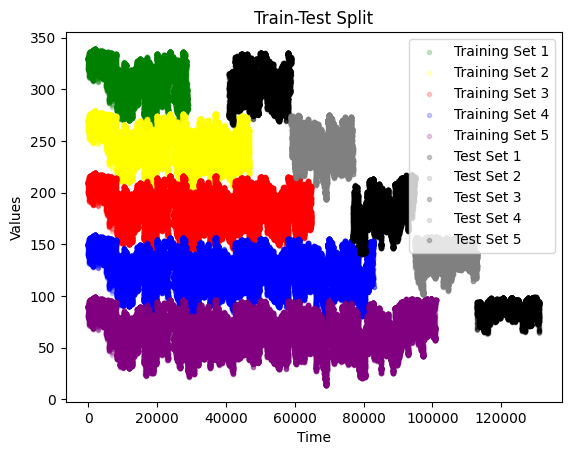

In [26]:
#create time-sensitive split for cross-validation
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=12000,
    test_size=18000
)

#apply split to the data
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]
train_1, test_1 = all_splits[1]
train_2, test_2 = all_splits[2]
train_3, test_3 = all_splits[3]
train_4, test_4 = all_splits[4]

#visualize train and test sets
# Plotting the training set indices
plt.scatter(X.iloc[train_0].index, X.iloc[train_0]['LC_HUMIDITY']+240, color='green', label='Training Set 1', alpha=0.2, marker='.')
plt.scatter(X.iloc[train_1].index, X.iloc[train_1]['LC_HUMIDITY']+180, color='yellow', label='Training Set 2', alpha=0.2, marker='.')
plt.scatter(X.iloc[train_2].index, X.iloc[train_2]['LC_HUMIDITY']+120, color='red', label='Training Set 3', alpha=0.2, marker='.')
plt.scatter(X.iloc[train_3].index, X.iloc[train_3]['LC_HUMIDITY']+60, color='blue', label='Training Set 4', alpha=0.2, marker='.')
plt.scatter(X.iloc[train_4].index, X.iloc[train_4]['LC_HUMIDITY'], color='purple', label='Training Set 5', alpha=0.2, marker='.')

# Plotting the testing set indices
plt.scatter(X.iloc[test_0].index, X.iloc[test_0]['LC_HUMIDITY']+240, color='black', label='Test Set 1', alpha=0.2, marker='.')
plt.scatter(X.iloc[test_1].index, X.iloc[test_1]['LC_HUMIDITY']+180, color='grey', label='Test Set 2', alpha=0.2, marker='.')
plt.scatter(X.iloc[test_2].index, X.iloc[test_2]['LC_HUMIDITY']+120, color='black', label='Test Set 3', alpha=0.2, marker='.')
plt.scatter(X.iloc[test_3].index, X.iloc[test_3]['LC_HUMIDITY']+60, color='grey', label='Test Set 4', alpha=0.2, marker='.')
plt.scatter(X.iloc[test_4].index, X.iloc[test_4]['LC_HUMIDITY'], color='black', label='Test Set 5', alpha=0.2, marker='.')

plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.title('Train-Test Split')
plt.show()

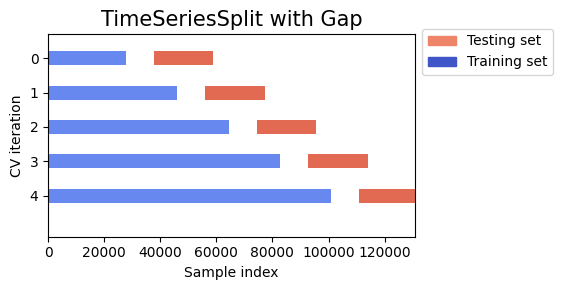

In [27]:

#some variables
cmap_cv = plt.cm.coolwarm
n_splits = 5

# Generate the dataset
n_points = len(X.index)
X = X
y = y

def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0
        
        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )
    
    # Formatting
    yticklabels = list(range(n_splits))
    ax.set(
        yticks=np.arange(n_splits) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 0.7, -0.2],
        xlim=[0, n_points],
    )
    ax.set_title("TimeSeriesSplit with Gap", fontsize=15)
    return ax

# Visualize cross-validation indices for TimeSeriesSplit with Gap
fig, ax = plt.subplots(figsize=(6, 3))
gap = 12960
test_size = 18340
cv = TimeSeriesSplit(n_splits, gap=gap, test_size=test_size)
plot_cv_indices(cv, X, y, ax, n_splits)

ax.legend(
    [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
    ["Testing set", "Training set"],
    loc=(1.02, 0.8),
)
# Make the legend fit
plt.tight_layout()
fig.subplots_adjust(right=0.7)
plt.show()


Create pipeline for Ridge with spline transformations

In [34]:

def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )
#creating spline transformers
cyclic_spline_transformer = ColumnTransformer(
    transformers=[
        ("cyclic_month", periodic_spline_transformer(12, n_splines=6), ["month"]),
        ("cyclic_weekday", periodic_spline_transformer(7, n_splines=3), ["day"]),
        ("cyclic_hour", periodic_spline_transformer(24, n_splines=12), ["hour"]),
    ],
    remainder=MinMaxScaler(),
)

#creating interactions
hour_holiday_interaction = make_pipeline(
    ColumnTransformer(
        [
            ("cyclic_hour", periodic_spline_transformer(24, n_splines=8), ["hour"]),
            ("holiday", FunctionTransformer(lambda x: x == 1), ["holiday"]),
        ]
    ),
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
)

day_holiday_interaction = make_pipeline(
    ColumnTransformer(
        [
            ("cyclic_weekday", periodic_spline_transformer(7, n_splines=3), ["day"]),
            ("holiday", FunctionTransformer(lambda x: x == 1), ["holiday"]),
        ]
    ),
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
)

hour_weekend_interaction = make_pipeline(
    ColumnTransformer(
        [
            ("cyclic_hour", periodic_spline_transformer(24, n_splines=8), ["hour"]),
            ("weekend", FunctionTransformer(lambda x: x == 1), ["weekend"]),
        ]
    ),
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
)

#adding combining the spline pipeline and the interactions pipeline
Ridge_splines = make_pipeline(
    FeatureUnion(
        [
            ("marginal", cyclic_spline_transformer),
            ("interactions1", hour_weekend_interaction),
            ("interactions2",day_holiday_interaction ),
            ("interactions3",hour_holiday_interaction),
            
        ]
    ),
    Ridge(),
)

In [45]:
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import Ridge

def evaluate_models(X, y, cv, models):
    best_model = None
    best_score = float('-inf')

    for model in models:
        if isinstance(model, XGBRegressor):
            # Parameter grid for XGBoost model
            param_grid = {
                'learning_rate': [0.05, 0.06],
                'n_estimators': [100, 110],
                'max_depth': [5, 6]
            }
        elif isinstance(model, HistGradientBoostingRegressor):
            # Parameter grid for HistGradientBoostingRegressor model
            param_grid = {
                'learning_rate': [0.04, 0.05, 0.06],
                'max_leaf_nodes': [8, 9, 10]
            }
        elif isinstance(model, Pipeline) and isinstance(model.steps[-1][1], Ridge):
            # Parameter grid for Ridge model with splines 
            param_grid = {
                "ridge__alpha": np.logspace(-6, 6, 25)
            }
        else:
            # Use default hyperparameters for other models
            best_model = model
            print(f"Using default hyperparameters for model: {type(model).__name__}")
            continue

        # Define custom scorer using mean absolute error
        scorer = 'neg_mean_squared_error'

        # Perform grid search with time series cross-validation
        grid_search = GridSearchCV(model, param_grid=param_grid, cv=cv, scoring=scorer)
        grid_search.fit(X, y)

        # Get the best parameters and score from the search
        best_params = grid_search.best_params_
        score = -grid_search.best_score_
        print(f"Results of Grid Search for model: {type(model).__name__}")
        print(f"Best Parameters: {best_params}")
        print(f"Best Score: {score}")

        if score > best_score:
            best_model = model.set_params(**best_params)
            best_score = score

        # Evaluate each model using time series cross-validation
        cv_results = cross_validate(
            best_model,
            X,
            y,
            cv=cv,
            scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
        )
        mae = -cv_results["test_neg_mean_absolute_error"]
        rmse = -cv_results["test_neg_root_mean_squared_error"]
        print(
            f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
            f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
        )
    return best_model


# Define the models to evaluate
models = [XGBRegressor(),HistGradientBoostingRegressor(),Pipeline([('ridge', Ridge())])]

# Example usage with multiple models
best_model = evaluate_models(X, y, ts_cv, models)


Results of Grid Search for model: XGBRegressor
Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
Best Score: 14.660874714669172
Mean Absolute Error:     2.618 +/- 0.416
Root Mean Squared Error: 3.781 +/- 0.603
Results of Grid Search for model: HistGradientBoostingRegressor
Best Parameters: {'learning_rate': 0.05, 'max_leaf_nodes': 10}
Best Score: 12.920801455025474
Mean Absolute Error:     2.618 +/- 0.416
Root Mean Squared Error: 3.781 +/- 0.603
Results of Grid Search for model: Pipeline
Best Parameters: {'ridge__alpha': 3162.2776601683795}
Best Score: 22.952010170471972
Mean Absolute Error:     3.627 +/- 0.424
Root Mean Squared Error: 4.766 +/- 0.487


In [46]:
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import Ridge
import numpy as np

def evaluate_models(X, y, cv, models):
    best_model = None
    best_score = float('-inf')

    for model in models:
        if isinstance(model, XGBRegressor):
            # Parameter grid for XGBoost model
            param_grid = {
                'learning_rate': [0.05, 0.06],
                'n_estimators': [100, 110],
                'max_depth': [5, 6]
            }
        elif isinstance(model, HistGradientBoostingRegressor):
            # Parameter grid for HistGradientBoostingRegressor model
            param_grid = {
                'learning_rate': [0.04, 0.05, 0.06],
                'max_leaf_nodes': [8, 9, 10]
            }
        elif isinstance(model, Pipeline) and isinstance(model.steps[-1][1], Ridge):
            # Parameter grid for Ridge model with splines 
            param_grid = {
                "ridge__alpha": np.logspace(-6, 6, 25)
            }
        else:
            # Use default hyperparameters for other models
            best_model = model
            print(f"Using default hyperparameters for model: {type(model).__name__}")
            continue

        # Define custom scorer using mean squared error
        scorer = 'neg_mean_squared_error'

        # Perform grid search with time series cross-validation
        grid_search = GridSearchCV(model, param_grid=param_grid, cv=cv, scoring=scorer)
        grid_search.fit(X, y)

        # Get the best parameters and score from the search
        best_params = grid_search.best_params_
        score = -grid_search.best_score_
        print(f"Results of Grid Search for model: {type(model).__name__}")
        print(f"Best Parameters: {best_params}")

        if score > best_score:
            best_model = model.set_params(**best_params)
            best_score = score

        # Evaluate each model using time series cross-validation
        cv_results = cross_validate(
            best_model,
            X,
            y,
            cv=cv,
            scoring=["neg_root_mean_squared_error"],
        )
        rmse = -cv_results["test_neg_root_mean_squared_error"]
        print(f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}")

    return best_model


# Define the models to evaluate
models = [XGBRegressor(), HistGradientBoostingRegressor(), Pipeline([('ridge', Ridge())])]

# Example usage with multiple models
best_model = evaluate_models(X, y, ts_cv, models)


Results of Grid Search for model: XGBRegressor
Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
Best Score: 14.660874714669172
Root Mean Squared Error: 3.781 +/- 0.603
Results of Grid Search for model: HistGradientBoostingRegressor
Best Parameters: {'learning_rate': 0.05, 'max_leaf_nodes': 9}
Best Score: 12.923050255238792
Root Mean Squared Error: 3.781 +/- 0.603


### Visualization of results of final model